In [128]:
import numpy as np
import multiprocessing #多线程处理
import cv2
import matplotlib.pyplot as plt #绘图


import rosbag #处理rosbag
from cv_bridge import CvBridge

import sys
sys.path.append('/home/gwp/rpg_vid2e/rosbag_reading')  # 替换为实际的路径(注意如果修改了py文件的代码需要重新restart kernel)
from utils.bag_utils import read_H_W_from_bag, read_tss_us_from_rosbag, read_images_from_rosbag, read_evs_from_rosbag, read_evs_from_rosbag_intimestamp
print("import ultils to process the rosbag")

import ultils to process the rosbag


In [129]:
rosbag_file="../example/HKU-dataset/HKU_aggressive_small_flip.bag"
# 从rosbag文件中读取数据
bag_data = rosbag.Bag(rosbag_file, "r")

topics = list(bag_data.get_type_and_topic_info()[1].keys())
print("all the topic name in this rosbag",topics)

all the topic name in this rosbag ['/cpy_uav/viconros/odometry', '/davis_left/events', '/davis_left/image_raw', '/davis_left/imu', '/davis_right/events', '/davis_right/image_raw', '/davis_right/imu']


In [130]:
event_topic_name='/davis_left/events';
image_topic_name='/davis_left/image_raw';

# 读取图像的长与宽
H, W = read_H_W_from_bag(bag_data, image_topic_name)
# 读取图像数据
imgs = read_images_from_rosbag(bag_data, image_topic_name, H=H, W=W)


Read H, W from bag: 260, 346


  0%|          | 0/1726 [00:00<?, ?it/s]

 27%|██▋       | 459/1726 [00:12<00:25, 49.70it/s]

 62%|██████▏   | 1066/1726 [00:28<00:17, 37.92it/s]

100%|██████████| 1726/1726 [00:47<00:00, 36.30it/s]


extract num of image 10


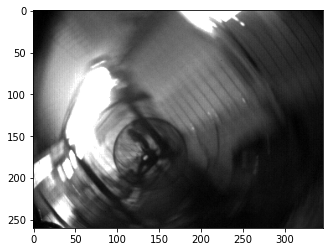

timestamp of the first image 1666334010130768.8 
timestamp of the last image 1666334010518417.8


In [131]:
# 获取一组图片
image_index=900;
image_set=imgs[image_index:image_index+10]#提取10张图片
print("extract num of image",len(image_set))

# 显示这张图片
image=image_set[1];
image_color = np.stack([image,image,image],-1)#将三个图像叠加，并沿着最后一个维度堆叠，形成一个彩色图像（RGB）。
plt.imshow(image_color)
plt.show()

# 读取图像的时间戳
timestamp_imgs_us = read_tss_us_from_rosbag(bag_data, image_topic_name)
#提取上面选择的10张图片对应的时间戳
timestamp_imgs_us_set=timestamp_imgs_us[image_index:image_index+10]
assert len(timestamp_imgs_us_set) == len(image_set)

timestamp_us_0=timestamp_imgs_us_set[0];#第一张图片的时间戳
timestamp_us_1=timestamp_imgs_us_set[-1];#最后一张图片的时间戳
print("timestamp of the first image",timestamp_us_0,"\ntimestamp of the last image",timestamp_us_1)


In [132]:
# 读取事件数据
all_events = read_evs_from_rosbag_intimestamp(bag_data, event_topic_name, timestamp_us_0, timestamp_us_1)


Start reading evs from /davis_left/events,事件的极性为1和-1


  1%|          | 23/4466 [00:10<33:49,  2.19it/s]


In [134]:
# print("the number of real event",len(all_events))

#  转换一下存储格式
real_events = {
    'x': np.array([event['x'] for event in all_events]),
    'y': np.array([event['y'] for event in all_events]),
    't': np.array([event['t'] for event in all_events]),
    'p': np.array([event['p'] for event in all_events])
}

print("the number of real event",len(real_events['x']))

the number of real event 803108


the number of real event stream 84641


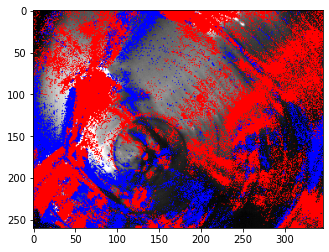

In [141]:
# 提取在第1~2帧时间内的事件
mask = (real_events['t'] >= timestamp_imgs_us_set[0]) & (real_events['t'] < timestamp_imgs_us_set[1])
real_event_stream = {k: v[mask] for k, v in real_events.items()}
print("the number of real event stream",len(real_event_stream['x']))

# 把real event画在image上, (H,W) -> (H,W,1) -> (H,W,3)
image_color = image[:, :, None].repeat(3, axis=2)
# 将事件数据与图像一起可视化出来
# # 把仿真的event画在image上
# image_color[real_event_stream['y'], real_event_stream['x'], :] = 0
# # 由于是BGR，所以-1的时候，对应1-1是蓝色，1的时候，1+1是红色
# image_color[real_event_stream['y'], real_event_stream['x'], 1+real_event_stream['p']] = 255

xytp = np.stack([real_event_stream['x'],
                 real_event_stream['y'], 
                 real_event_stream['t'], 
                 real_event_stream['p']], -1).astype(np.int64)  # (N,4)
neg_mask = (xytp[:, -1] == -1)
pos_mask = (xytp[:, -1] == 1)

# 这样做法避免了叠加产生粉红色
image_color[xytp[neg_mask][:, 1], xytp[neg_mask][:, 0]] = np.array([[0., 0., 255.,]]) #将-事件的位置设置为blue
image_color[xytp[pos_mask][:, 1], xytp[pos_mask][:, 0]] = np.array([[255., 0., 0.,]]) #将+事件的位置设置为red

plt.imshow(image_color)
plt.show()

In [149]:
import torch
import esim_torch
t_refractory_period_ns=1e3;#某个时间段内不会产生event
esim = esim_torch.ESIM(contrast_threshold_neg=0.45, #定义负event的阈值
                        contrast_threshold_pos=0.45, #定义正event的阈值
                        refractory_period_ns=t_refractory_period_ns)  #refractory period in nanoseconds

images = np.stack(image_set)
timestamp_imgs_us_set = np.stack(timestamp_imgs_us_set)
timestamps_ns = ((timestamp_imgs_us_set - timestamp_imgs_us_set[0]) * 1e3).astype("int64")  # shift to zero and convert to ns
# timestamps_ns=(np.stack(timestamp_imgs_us_set)*1e3).astype("int64")#转换为ns

# 将图片转换为log scale
log_images = np.log(images.astype("float32") / 255 + 1e-4)

# generate torch tensors
print("Loading data to GPU")
device = "cuda:0"
# torch tensor with type float32, shape T x H x W
log_images = torch.from_numpy(log_images).to(device)
# torch tensor with type int64,   shape T (已经转换为tensor)
timestamps_ns = torch.from_numpy(timestamps_ns).to(device)

# generate events with GPU support
print("Generating events")
sim_events = esim.forward(log_images, timestamps_ns)

all_sim_event = sim_events
print(f"number of sim events: {all_sim_event['x'].shape}")


Loading data to GPU
Generating events
number of sim events: torch.Size([780927])


the number of sim event stream 94899


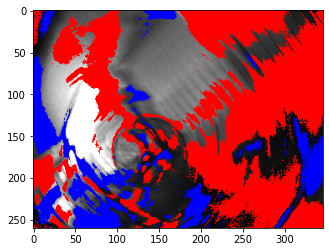

the number of sim event stream 84641


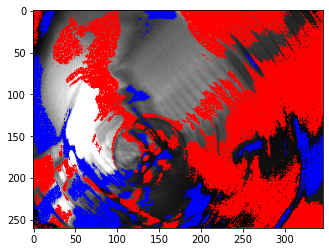

In [150]:
# 获取第一帧到第二帧之间的事件
timestamps_ns0=timestamps_ns[0].item() #读取时间戳(注意前面转换成torch了)
timestamps_ns1=timestamps_ns[1].item() #读取时间戳
sim_mask = (all_sim_event['t'] >= timestamps_ns0) & (all_sim_event['t'] < timestamps_ns1)

# 随机选择50000个事件
# sim_mask = np.random.choice(sim_mask.cpu().sum(), 50000, replace=False)

sim_event_stream = {k: v[sim_mask].cpu().numpy() for k, v in all_sim_event.items()}
print("the number of sim event stream",len(sim_event_stream['x']))

# # 把仿真的event画在image上
# image_color[sim_event_stream['y'], sim_event_stream['x'], :] = 0
# image_color[sim_event_stream['y'], sim_event_stream['x'], 1+sim_event_stream['p']] = 255

# 将image_color重新生成一次
image_color = np.stack([image,image,image],-1)
xytp = np.stack([sim_event_stream['x'],
                 sim_event_stream['y'], 
                 sim_event_stream['t'], 
                 sim_event_stream['p']], -1).astype(np.int64)  # (N,4)
neg_mask = (xytp[:, -1] == -1)
pos_mask = (xytp[:, -1] == 1)

# 这样做法避免了叠加产生粉红色
image_color[xytp[neg_mask][:, 1], xytp[neg_mask][:, 0]] = np.array([[0., 0., 255.,]]) #将-事件的位置设置为blue
image_color[xytp[pos_mask][:, 1], xytp[pos_mask][:, 0]] = np.array([[255., 0., 0.,]]) #将+事件的位置设置为red

plt.imshow(image_color)
plt.show()


sim_mask = np.random.choice(sim_mask.cpu().sum(), 84641, replace=False)
sim_event_stream = {k: v[sim_mask].cpu().numpy() for k, v in all_sim_event.items()}
print("the number of sim event stream",len(sim_event_stream['x']))
image_color = np.stack([image,image,image],-1)
xytp = np.stack([sim_event_stream['x'],
                 sim_event_stream['y'], 
                 sim_event_stream['t'], 
                 sim_event_stream['p']], -1).astype(np.int64)  # (N,4)
neg_mask = (xytp[:, -1] == -1)
pos_mask = (xytp[:, -1] == 1)

# 这样做法避免了叠加产生粉红色
image_color[xytp[neg_mask][:, 1], xytp[neg_mask][:, 0]] = np.array([[0., 0., 255.,]]) #将-事件的位置设置为blue
image_color[xytp[pos_mask][:, 1], xytp[pos_mask][:, 0]] = np.array([[255., 0., 0.,]]) #将+事件的位置设置为red

plt.imshow(image_color)
plt.show()
